# Data Analysis

In [1]:
import matplotlib.pyplot as plt
import matplotlib
font = {'weight' : 'bold',
        'size'   : 14}

matplotlib.rc('font', **font)

## Get Work Zone Data

In [2]:
import xml.etree.ElementTree as ET
import collections
from ast import literal_eval
import glob
import os
import re
import pandas as pd


def get_points(polygon):
    points = polygon.attrib["points"].split(';')
    points_list = list()
    for point in points:
        points_list.append(literal_eval(point))
    return points_list, len(points_list)

def parseXML(xmlfile):
    data = collections.defaultdict(dict)    
    try:
        tree = ET.parse(xmlfile) # create element tree object
        # get root element
        root = tree.getroot()
        for image in root.findall("image"):
            image_name = image.attrib["name"]
            objects = collections.defaultdict(list, {k:[] for k in ("cone", "#cone", 
                                                                    "drum", "#drum", 
                                                                    "barricade", "#barricade", 
                                                                    "board", "#board", 
                                                                    "trailer", "#trailer", 
                                                                    "other", "#other", 
                                                                    "unknown", "#unknown", 
                                                                    "machine", "#machine", 
                                                                    "sign", "#sign", 
                                                                    "barrier", "#barrier", 
                                                                    "person", "#person",
                                                                    "#total")})                        
            
            for polygon in image.findall("polygon"):                
                label = polygon.attrib["label"]
                points, _ = get_points(polygon)
                
                # search for workzone related objects
                if (label == "workzone") and (polygon.find("attribute").text == "cone"):                    
                    objects["cone"].append(points)     
                elif (label == "workzone") and (polygon.find("attribute").text == "drum"):                    
                    objects["drum"].append(points)
                elif (label == "workzone") and (polygon.find("attribute").text == "barricade"):                    
                    objects["barricade"].append(points)
                elif (label == "workzone") and (polygon.find("attribute").text == "board"):                    
                    objects["board"].append(points)
                elif (label == "workzone") and (polygon.find("attribute").text == "trailer"):                    
                    objects["trailer"].append(points)
                elif (label == "workzone") and (polygon.find("attribute").text == "other"):                    
                    objects["other"].append(points)                             
                elif (label == "workzone") and (polygon.find("attribute").text == "unknown"):                    
                    objects["unknown"].append(points)                   
                elif label == "machine":                    
                    objects["machine"].append(points)                    
                elif label == "construction_sign":
                    objects["sign"].append(points)                    
                elif (label == "barrier") and (polygon.find("attribute").text == "workzone"):
                    objects["barrier"].append(points)                    
                elif (label == "person") and (polygon.find("attribute").text == "construction_worker"):
                    objects["person"].append(points)  
                    
            # accumulating counts       
            objects["#cone"] = len(objects["cone"])
            objects["#drum"] = len(objects["drum"])
            objects["#barricade"] = len(objects["barricade"])
            objects["#board"] = len(objects["board"])
            objects["#trailer"] = len(objects["trailer"])
            objects["#other"] = len(objects["other"])
            objects["#unknown"] = len(objects["unknown"])            
            objects["#machine"] = len(objects["machine"])
            objects["#sign"] = len(objects["sign"])
            objects["#barrier"] = len(objects["barrier"])
            objects["#person"] = len(objects["person"])
            total = len(objects["cone"]) + len(objects["drum"]) + len(objects["barricade"]) + len(objects["board"]) + len(objects["trailer"]) + len(objects["other"]) + len(objects["unknown"]) + len(objects["machine"]) + len(objects["sign"]) + len(objects["barrier"]) + len(objects["person"])
            objects["#total"] = total            
            data[image_name] = objects 
        print(len(data))
        return data
    
    except Exception as e:
        print(e, xmlfile)
        return None

def get_wzdf(path):  # workzone dataframe
    path = os.path.join(path, '**', '*.xml')  
    data = list()    
    for xmlfile in glob.iglob(path, recursive=True): 
        print(f"Processing: {xmlfile}...")
        image_root = os.path.join(re.findall("(.+)/", xmlfile)[0], "Images")
        xml_data = parseXML(xmlfile)
        if xml_data is not None:
            for item in xml_data.items():
                temp = list()
                # image name
                image_name = item[0]
                temp.append(image_name)  
                # image path
                image_path = os.path.join(image_root, image_name)
                temp.append(image_path)
                # object dictionary
                obj_dict = item[1]   
                # objects
                for k, v in obj_dict.items(): # order of keys: ("cone", "drum", "barricade", "board", "trailer", "other", "unknown", "machine", "sign", "barrier", "person")                      
                    if not v:
                        temp.append(None)
                        continue
                    else:
                        temp.append(v)
                data.append(temp)        
    df = pd.DataFrame(data, columns=["name", "path", 
                                     "cone", "#cone", 
                                     "drum", "#drum", 
                                     "barricade", "#barricade", 
                                     "board", "#board", 
                                     "trailer", "#trailer", 
                                     "other", "#other", 
                                     "unknown", "#unknown", 
                                     "machine", "#machine", 
                                     "sign", "#sign", 
                                     "barrier", "#barrier", 
                                     "person", "#person",
                                     "#total"])
    return df


In [3]:
# make directory to storee results
os.makedirs("../output/analysis", exist_ok=True)
os.makedirs("../output/analysis/object_distribution", exist_ok=True)
os.makedirs("../output/analysis/heat_map", exist_ok=True)
os.makedirs("../output/analysis/csv", exist_ok=True)
os.makedirs("../output/analysis/pixel_distribution", exist_ok=True)
os.makedirs("../output/analysis/color_distribution", exist_ok=True)

path = "../data/Delivery_1_Workzone"
data = get_wzdf(path)
data.fillna(value=0, inplace=True)
data.to_csv("../output/analysis/csv/wz_data.csv")

Processing: ../data/Delivery_1_Workzone/Day/Batch 1.2/Workzone_Day_Batch1.2.xml...
449
Processing: ../data/Delivery_1_Workzone/Day/Batch 2/Workzone_Day_Batch2.xml...
840
Processing: ../data/Delivery_1_Workzone/Day/Batch 1.1/Workzone_Day_Batch1.1.xml...
470
Processing: ../data/Delivery_1_Workzone/Day/Batch 3/Workzone_Day_Batch3.xml...
45
Processing: ../data/Delivery_1_Workzone/Night/Workzone_Night_Batch1.xml...
198


## Data Distribution Analysis

#### All Data

In [4]:
def plot_distribution(data, obj):
    fig, ax = plt.subplots(figsize=(10, 10))
    data = data[f"#{obj}"].astype("int32")
    data.value_counts().sort_index().plot(ax=ax, kind='bar', grid=True, label=f"Number of workzone {obj}")    
    plt.legend(loc="upper right")
    plt.axis([0.5, 37, 0, 250]) #only for total distribution
    plt.xlabel(f"No. of work zone objects", fontsize=20) #only for total distribution
    plt.ylabel("No. of work zone images", fontsize=20)
    #plt.xlabel(f"Workzone {obj} count", fontsize=20)
    
    #plt.title(f"Workzone {obj} distribution", fontsize=20)
    plt.savefig(f"../output/analysis/object_distribution/{obj}_distribution.png", dpi=200, bbox_inches = "tight")
    plt.show()    

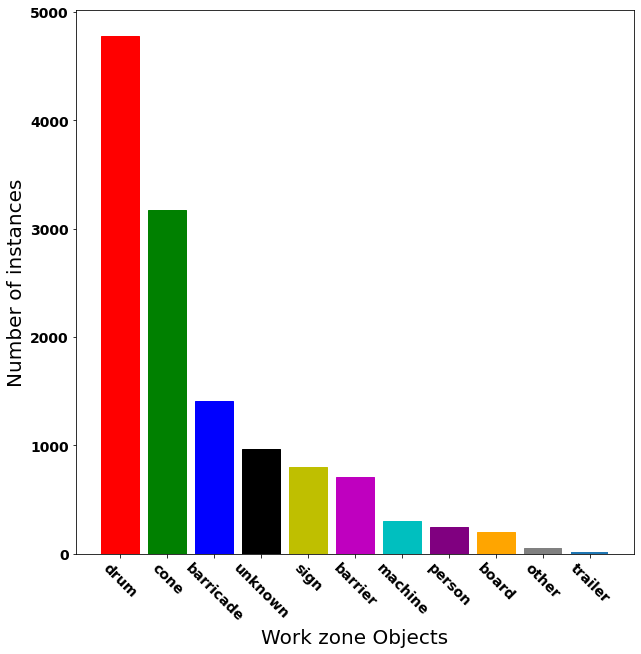

In [5]:
fig, ax = plt.subplots(figsize=(10, 10))
total_cone = data["#cone"].sum()
total_drum = data["#drum"].sum()
total_barricade = data["#barricade"].sum()
total_board = data["#board"].sum()
total_trailer = data["#trailer"].sum()
total_other = data["#other"].sum()
total_unknown = data["#unknown"].sum()
total_machine = data["#machine"].sum()
total_sign = data["#sign"].sum()
total_barrier = data["#barrier"].sum()
total_person = data["#person"].sum()
x = [ "drum", "cone", "barricade", "unknown", "sign", "barrier", "machine", "person", "board", "other", "trailer"]
y = [total_drum, total_cone, total_barricade, total_unknown, total_sign, total_barrier, total_machine, total_person, total_board, total_other, total_trailer]
barlist = plt.bar(x, y)
barlist[0].set_color('r')
barlist[1].set_color('g')
barlist[2].set_color('b')
barlist[3].set_color('k')
barlist[4].set_color('y')
barlist[5].set_color('m')
barlist[6].set_color('c')
barlist[7].set_color('#800080')
barlist[8].set_color('#FFA500')
barlist[9].set_color('#808080')

ax.set_ylabel("Number of instances", fontsize=20)
ax.set_xlabel("Work zone Objects", fontsize=20)
# ax.set_title('All Workzone Objects Distribution', fontsize=20)
plt.xticks(rotation=-45)
plt.savefig('../output/analysis/object_distribution/all_workzone_objects_distribution.png', dpi=200, bbox_inches = "tight")
plt.show()

### Workzone Objects Distribution

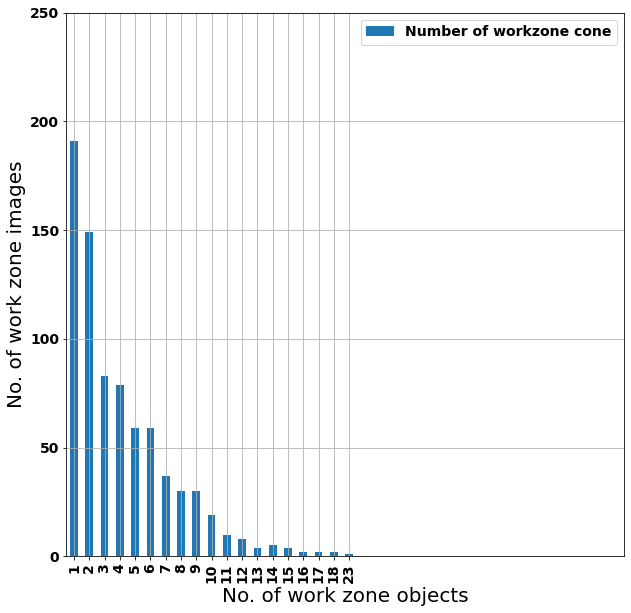

In [6]:
# cones
plot_distribution(data, "cone")

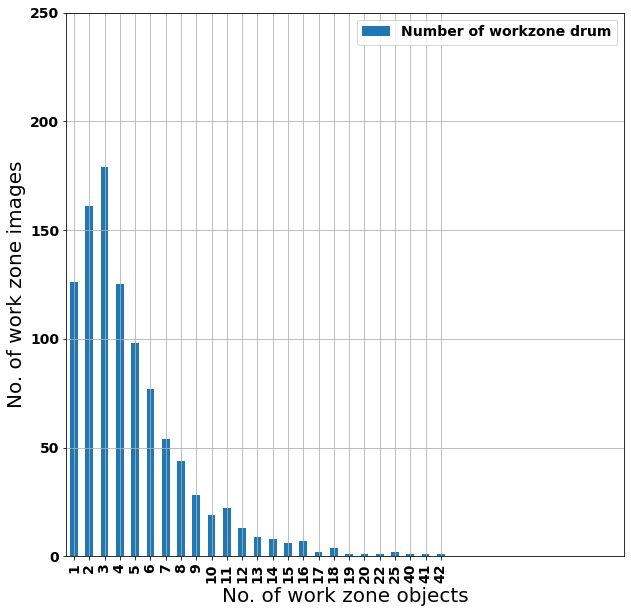

In [7]:
# drums
plot_distribution(data, "drum")

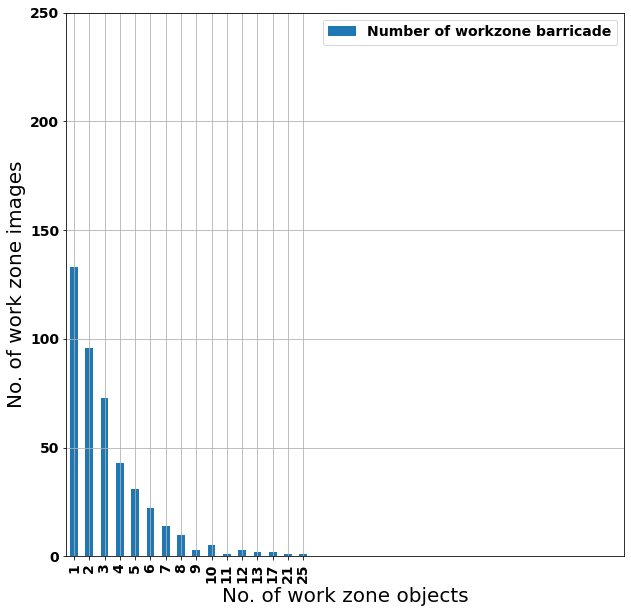

In [8]:
# barricade
plot_distribution(data, "barricade")

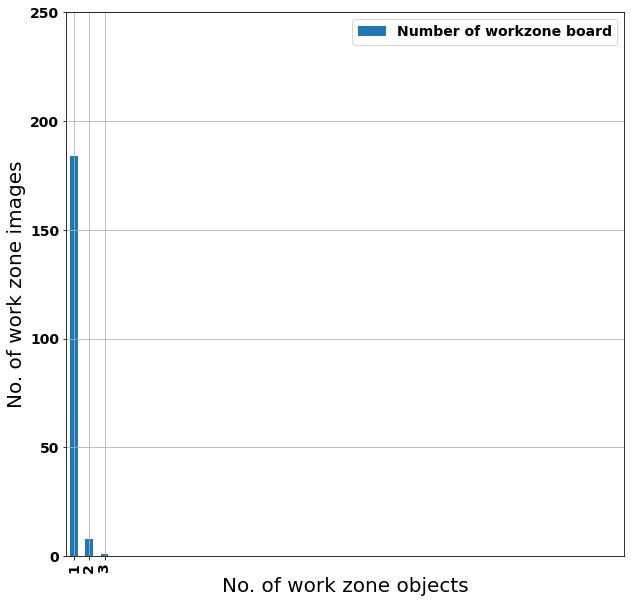

In [9]:
plot_distribution(data, "board")

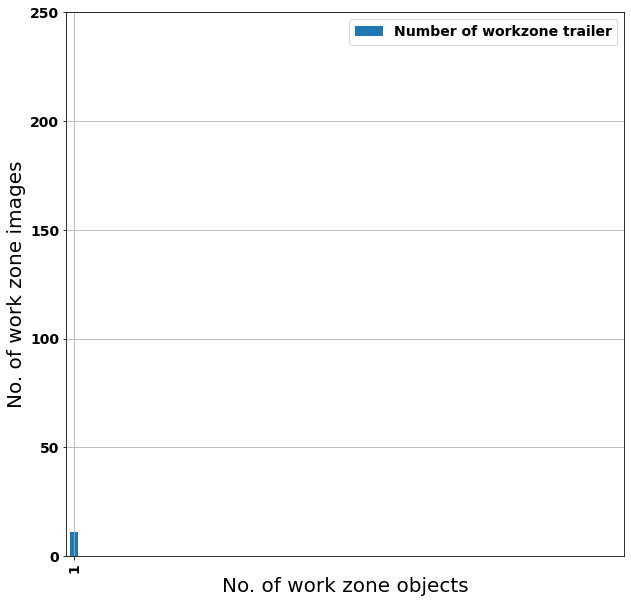

In [10]:
plot_distribution(data, "trailer")

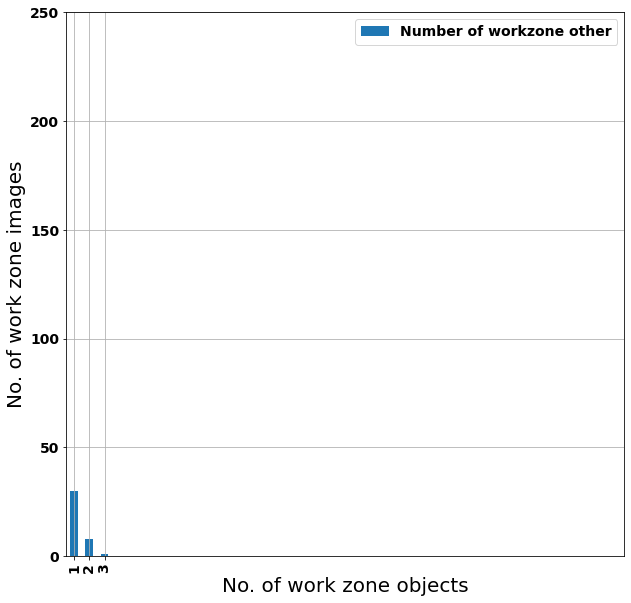

In [11]:
plot_distribution(data, "other")

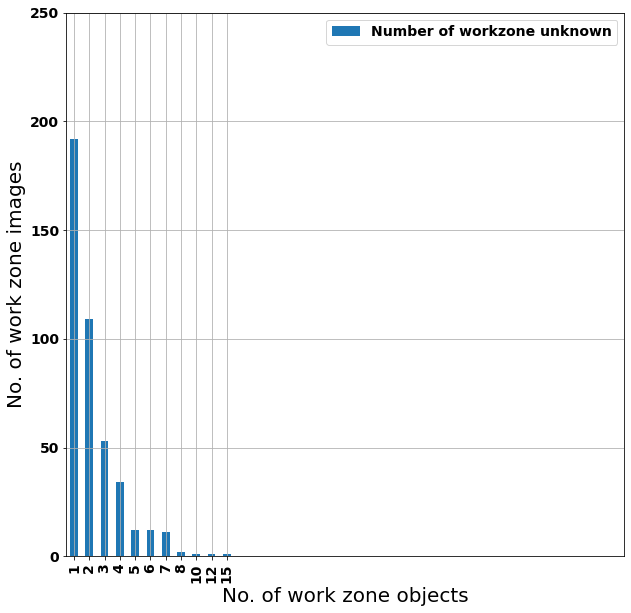

In [12]:
plot_distribution(data, "unknown")

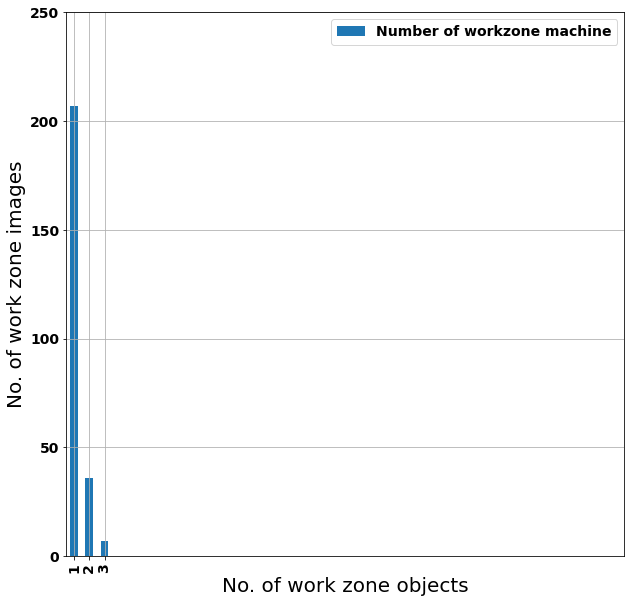

In [13]:
plot_distribution(data, "machine")

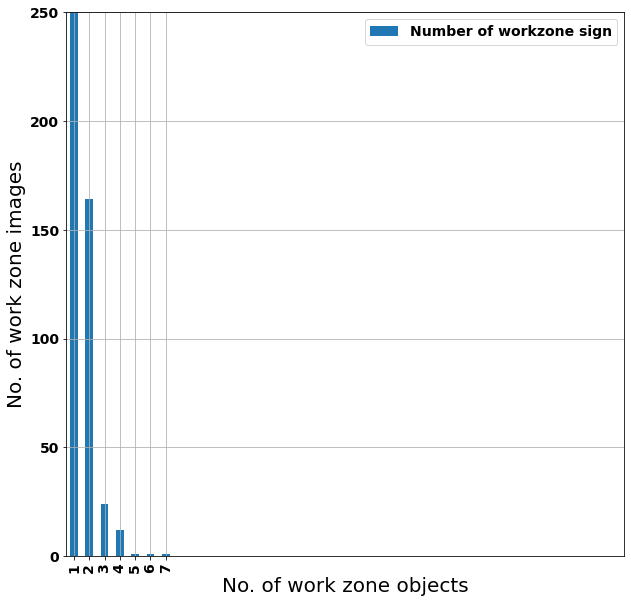

In [14]:
plot_distribution(data, "sign")

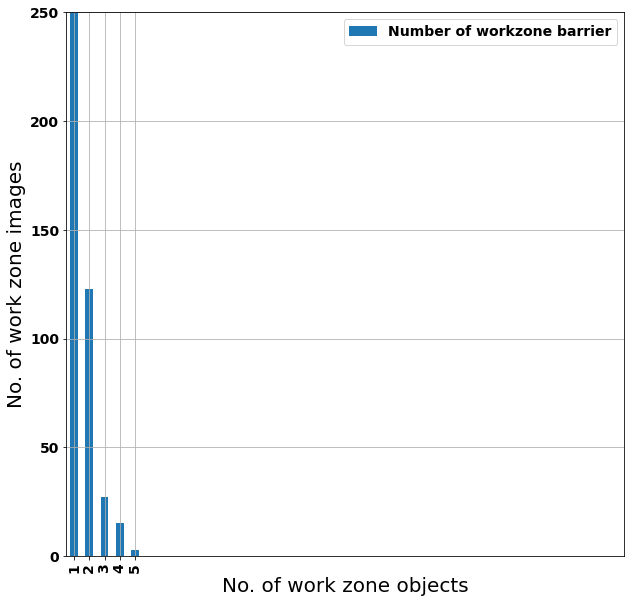

In [15]:
plot_distribution(data, "barrier")

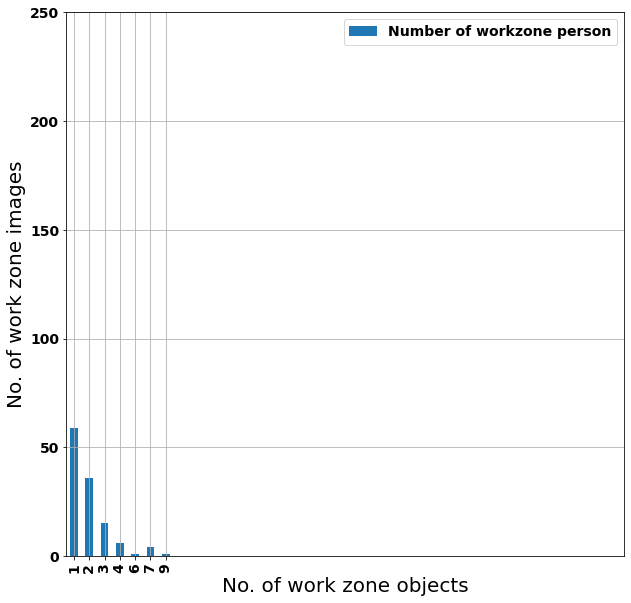

In [16]:
plot_distribution(data, "person")

### Dense Medium Sparse

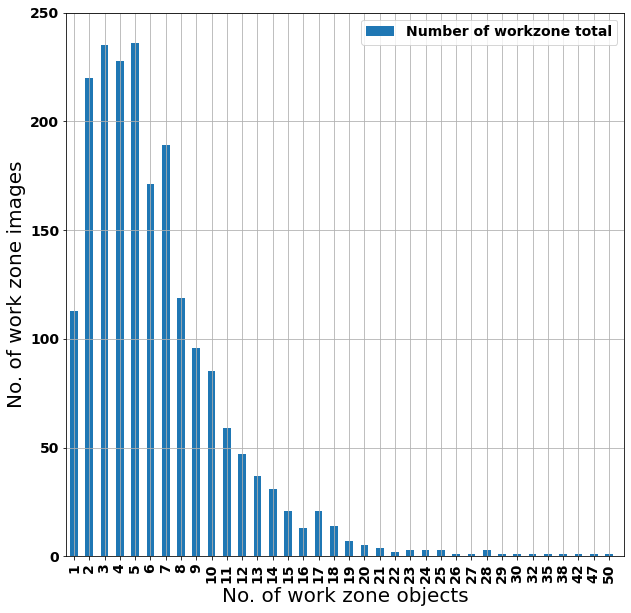

In [17]:
plot_distribution(data, "total")

## Heat Map Analysis

### Utils

In [18]:
import PIL
from PIL import Image, ImageDraw
import numpy as np
import cv2
from tqdm import tqdm
import sys

class GetHeatMap():
    
    def __init__(self, df, obj, thresh=10, resize_shape=(720, 480)):
        self.df = df
        self.obj = obj
        self.thresh = thresh
        self.w, self.h = resize_shape
        self.c = len(df)
        
    def get_mask(self, polygons, image_shape, outline=True):
        orig_width, orig_height = image_shape
        mask = Image.new('L', (orig_width, orig_height))  # workzone mask              
        if not polygons:
            return mask.resize((self.w, self.h), PIL.Image.NEAREST)         
        else:
            for polygon in polygons:
                polygon_points = [tuple(map(int, point)) for point in polygon]
                ImageDraw.Draw(mask).polygon(polygon_points, outline="white", fill="white")                   
            if outline:
                mask = mask.resize((self.w, self.h), PIL.Image.NEAREST)
                mask_outline = self.get_mask_outline(mask)                
                return mask_outline
            else:
                mask = mask.resize((self.w, self.h), PIL.Image.NEAREST)
                mask = np.array(mask)                
                return  mask
        
    def get_mask_outline(self, mask):
        mask = np.array(mask)       
        mask_w = cv2.erode(mask, kernel=np.ones((8,8), np.uint8), iterations=1)
        mask_w = mask-mask_w
        return mask_w   
    
    def get_map(self, masks):
        masks = masks // 255
        heat_map = np.sum(masks, axis=0)  
        heat_map = (heat_map > self.thresh) * heat_map
        return heat_map
    
    def plot(self):
        masks, heatmap = self.generate()
        plt.axis("off")
        plt.imshow(heatmap, cmap="viridis")
        plt.title(f"workzone {self.obj} heatmap", fontsize=20)
        plt.savefig(f"../output/analysis/heat_map/{self.obj}_heatmap.png", dpi=250, bbox_inches = "tight")    
    
    def generate(self):
        masks = np.zeros(shape=(self.c, self.h, self.w), dtype=np.uint8)           
        
        for index, row in tqdm(self.df.iterrows(), file=sys.stdout):
                        
            name, path = row.iloc[0], row.iloc[1]   
            image = Image.open(path)
            image_shape_wh = image.size
        
            # ("cone", "drum", "barricade", "board", "trailer", "other", "unknown", "machine", "sign", "barrier", "person") 
            if self.obj == "cone":                
                polygons, num  = row.iloc[2], row.iloc[3] 
                mask = self.get_mask(polygons, image_shape_wh) # mask.shape = (h, w)                
                masks[index] = mask   

            elif self.obj == "drum":                
                polygons, num  = row.iloc[4], row.iloc[5] 
                mask = self.get_mask(polygons, image_shape_wh) # mask.shape = (h, w)                
                masks[index] = mask   

            elif self.obj == "barricade":                
                polygons, num  = row.iloc[6], row.iloc[7] 
                mask = self.get_mask(polygons, image_shape_wh) # mask.shape = (h, w)                
                masks[index] = mask

            elif self.obj == "board":                
                polygons, num  = row.iloc[8], row.iloc[9] 
                mask = self.get_mask(polygons, image_shape_wh) # mask.shape = (h, w)                
                masks[index] = mask

            elif self.obj == "trailer":                
                polygons, num  = row.iloc[10], row.iloc[11] 
                mask = self.get_mask(polygons, image_shape_wh) # mask.shape = (h, w)                
                masks[index] = mask

            elif self.obj == "other":                
                polygons, num  = row.iloc[12], row.iloc[13] 
                mask = self.get_mask(polygons, image_shape_wh) # mask.shape = (h, w)                
                masks[index] = mask

            elif self.obj == "unknown":                
                polygons, num  = row.iloc[14], row.iloc[15] 
                mask = self.get_mask(polygons, image_shape_wh) # mask.shape = (h, w)                
                masks[index] = mask                

            elif self.obj == "machine":
                polygons, num = row.iloc[16], row.iloc[17]
                mask = self.get_mask(polygons, image_shape_wh, outline=False) # mask.shape = (h, w)                
                masks[index] = mask

            elif self.obj == "sign":
                polygons, num = row.iloc[18], row.iloc[19]
                mask = self.get_mask(polygons, image_shape_wh) # mask.shape = (h, w)                
                masks[index] = mask      

            elif self.obj == "barrier":
                polygons, num  = row.iloc[20], row.iloc[21]
                mask = self.get_mask(polygons, image_shape_wh) # mask.shape = (h, w)               
                masks[index] = mask

            elif self.obj == "person":
                polygons, num  = row.iloc[22], row.iloc[23]
                mask = self.get_mask(polygons, image_shape_wh, outline=False) # mask.shape = (h, w)                
                masks[index] = mask
                
            elif sel.obj == "all":
                pass
                
            else:
                raise Exception(f"{self.obj} is an invalid workzone object type")         
        heatmap = self.get_map(masks)        
        return masks, heatmap       

### Heat Maps 

#### Workzone Cone

2002it [00:03, 556.34it/s]


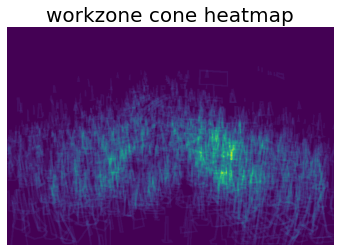

In [19]:
cone_heatmap = GetHeatMap(df=data, obj="cone", thresh=0)
cone_heatmap.plot()

#### Workzone drums 

2002it [00:03, 564.29it/s]


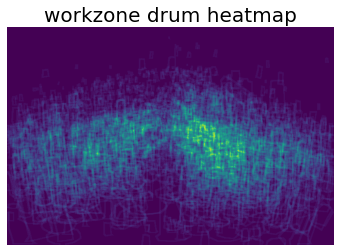

In [20]:
drum_heatmap = GetHeatMap(df=data, obj="drum", thresh=0)
drum_heatmap.plot()

#### Workzone barricade

2002it [00:05, 385.16it/s]


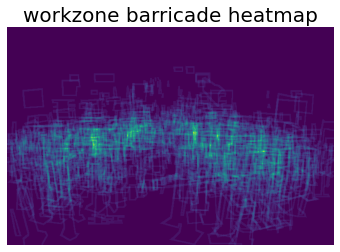

In [21]:
barricade_heatmap = GetHeatMap(df=data, obj="barricade", thresh=0)
barricade_heatmap.plot()

#### Workzone board

2002it [00:04, 430.13it/s]


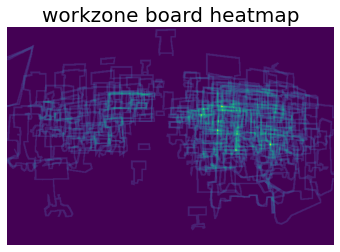

In [22]:
board_heatmap = GetHeatMap(df=data, obj="board", thresh=0)
board_heatmap.plot()

#### Workzone trailer 

2002it [00:03, 609.64it/s]


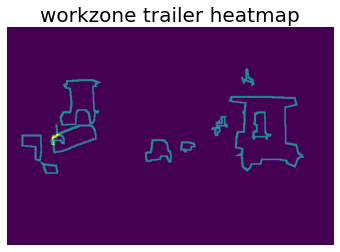

In [23]:
trailer_heatmap = GetHeatMap(df=data, obj="trailer", thresh=0)
trailer_heatmap.plot()

#### Workzone other

2002it [00:03, 568.46it/s]


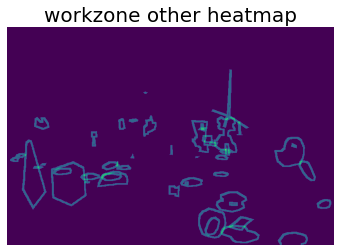

In [24]:
other_heatmap = GetHeatMap(df=data, obj="other", thresh=0)
other_heatmap.plot()

### Workzone unknown

2002it [00:03, 596.81it/s]


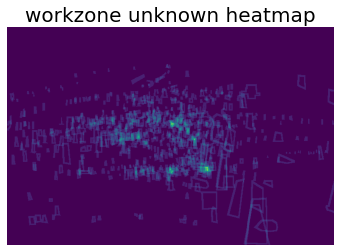

In [25]:
unknown_heatmap = GetHeatMap(df=data, obj="unknown", thresh=0)
unknown_heatmap.plot()

#### Workzone Sign

2002it [00:04, 484.13it/s]


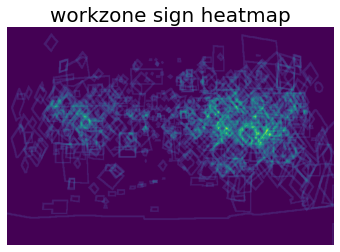

In [26]:
sign_heatmap = GetHeatMap(df=data, obj="sign", thresh=0)
sign_heatmap.plot()

#### Workzone Barrier

2002it [00:03, 556.35it/s]


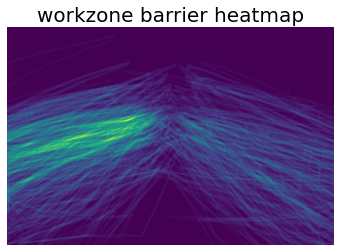

In [27]:
barrier_heatmap = GetHeatMap(df=data, obj="barrier", thresh=0)
barrier_heatmap.plot()

#### Workzone Construction Workers

2002it [00:03, 624.76it/s]


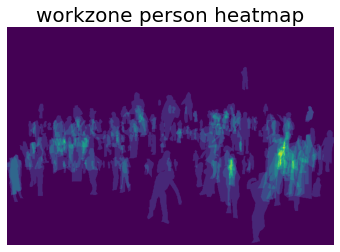

In [28]:
worker_heatmap = GetHeatMap(df=data, obj="person", thresh=0)
worker_heatmap.plot()

#### Workzone machine

2002it [00:03, 631.30it/s]


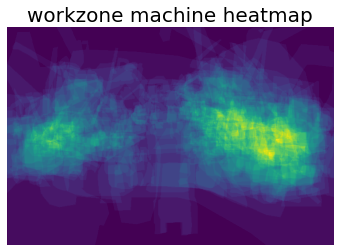

In [29]:
machine_heatmap = GetHeatMap(df=data, obj="machine", thresh=0)
machine_heatmap.plot()

## Pixel Distribution

In [30]:
import PIL
from PIL import Image, ImageDraw
import numpy as np
import cv2
from tqdm import tqdm
import sys
import itertools

class GetPixelDistribution():
    
    def __init__(self, df, obj, resize_shape=(720, 480)):
        self.df = df
        self.obj = obj        
        self.w, self.h = resize_shape
        self.c = len(df)
        
    def get_pixel_count(self, polygons, image_shape, outline=True, esp=1e-5):
        orig_width, orig_height = image_shape
        mask = Image.new('L', (orig_width, orig_height))  # workzone mask     
        if not polygons:
            return 0
        else:
            for polygon in polygons:
                polygon_points = [tuple(map(int, point)) for point in polygon]
                ImageDraw.Draw(mask).polygon(polygon_points, outline="white", fill="white")                   
            mask = mask.resize((self.w, self.h), PIL.Image.NEAREST)
            mask = np.array(mask) // 255
            pixel_percentage = round(100*(np.sum(mask) / (self.w * self.h + esp)), 2)            
            return pixel_percentage
    
    def generate(self):
        counts = list()        
        for index, row in tqdm(self.df.iterrows(), file=sys.stdout):
                        
            name, path = row.iloc[0], row.iloc[1]               
            image = Image.open(path)
            image_shape_wh = image.size
            
            try:
                # ("cone", "drum", "barricade", "board", "trailer", "other", "unknown", "machine", "sign", "barrier", "person") 
                if self.obj == "cone":                
                    polygons, num  = row.iloc[2], row.iloc[3]                 
                    count = self.get_pixel_count(polygons, image_shape_wh)                 
                    counts.append(count)  

                elif self.obj == "drum":                
                    polygons, num  = row.iloc[4], row.iloc[5] 
                    count = self.get_pixel_count(polygons, image_shape_wh)                
                    counts.append(count)    

                elif self.obj == "barricade":                
                    polygons, num  = row.iloc[6], row.iloc[7] 
                    count = self.get_pixel_count(polygons, image_shape_wh)                
                    counts.append(count) 

                elif self.obj == "board":                
                    polygons, num  = row.iloc[8], row.iloc[9] 
                    count = self.get_pixel_count(polygons, image_shape_wh)                
                    counts.append(count) 

                elif self.obj == "trailer":                
                    polygons, num  = row.iloc[10], row.iloc[11] 
                    count = self.get_pixel_count(polygons, image_shape_wh)                
                    counts.append(count) 

                elif self.obj == "other":                
                    polygons, num  = row.iloc[12], row.iloc[13] 
                    count = self.get_pixel_count(polygons, image_shape_wh)                
                    counts.append(count) 

                elif self.obj == "unknown":                
                    polygons, num  = row.iloc[14], row.iloc[15] 
                    count = self.get_pixel_count(polygons, image_shape_wh)                
                    counts.append(count)                 

                elif self.obj == "machine":
                    polygons, num = row.iloc[16], row.iloc[17]
                    count = get_pixel_count(polygons, image_shape_wh)                
                    counts.append(count) 

                elif self.obj == "sign":
                    polygons, num = row.iloc[18], row.iloc[19]
                    count = self.get_pixel_count(polygons, image_shape_wh)                
                    counts.append(count)       

                elif self.obj == "barrier":
                    polygons, num  = row.iloc[20], row.iloc[21]
                    count = self.get_pixel_count(polygons, image_shape_wh)                
                    counts.append(count) 

                elif self.obj == "person":
                    polygons, num  = row.iloc[22], row.iloc[23]
                    count = self.get_pixel_count(polygons, image_shape_wh)                
                    counts.append(count) 
                    
                elif self.obj == "all":
                    total = list()
                    loc = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22]
                    for i in loc:
                        polygons = row.iloc[i]
                        if polygons != 0:
                            total.append(polygons)
                    total = list(itertools.chain.from_iterable(total))                       
                    count = self.get_pixel_count(total, image_shape_wh)                 
                    counts.append(count)                       
                
            except Exception as e:
                print(e)     
        return counts     

In [31]:
import math
pixel_dist = GetPixelDistribution(df=data, obj="all")
count = np.array(pixel_dist.generate())
print(count.shape)
print(f"Average coverage: {np.mean(count)}%")

2002it [00:07, 266.21it/s]
(2002,)
Average coverage: 2.111298701298701%


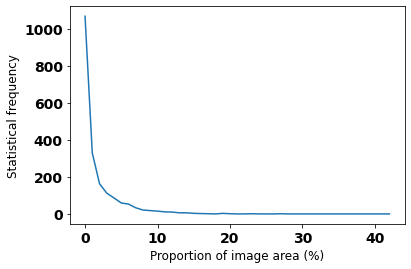

True
2001


In [32]:
histogram, bin_edges = np.histogram(count, range=(count.min(), 43), bins=43, density=False)

plt.xlabel("Proportion of image area (%)",fontsize=12)
plt.ylabel("Statistical frequency", fontsize=12)
# plt.title(f"Pixel Distribution", fontsize=14)
plt.plot(bin_edges[:-1], histogram)
plt.savefig(f"../output/analysis/pixel_distribution/pixel_distribution.png", dpi=200, bbox_inches = "tight")
plt.show()
# sanity check
print(np.all(np.diff(bin_edges)==1))
print(np.sum(histogram))

## Color Histogram Analysis of Workzone Objects 

In [33]:
df = pd.read_csv("../output/analysis/csv/wz_data.csv")

In [34]:
class color_histogram():
    def __init__(self, df, obj):
        self.df = df
        self.obj = obj
        
    def get_mask(self, polygons, image_shape):
        orig_width, orig_height = image_shape
        mask = Image.new('L', (orig_width, orig_height))  # workzone mask              
        for polygon in polygons:           
            polygon_points = [tuple(map(int, point)) for point in polygon]
            ImageDraw.Draw(mask).polygon(polygon_points, outline="white", fill="white")                          
        return np.array(mask, dtype=np.uint8)        
    
    def generate(self):
        """https://note.nkmk.me/en/python-numpy-image-processing/"""
        R = list()
        G = list()
        B = list()
        for index, row in tqdm(self.df.iterrows(), file=sys.stdout):
            name, path = row.iloc[0], row.iloc[1]   
            image = Image.open(path)  # opening image in RGB mode                        
            image_shape_wh = image.size            
            polygons = literal_eval(row.iloc[2])            
            mask = self.get_mask(polygons, image_shape_wh) # mask.shape = (h, w)  
            mask = np.expand_dims(mask, axis=2) // 255
            
            image = np.array(image) # order of colors (channels) is RGB 
            image = np.multiply(image, mask)
            
            # R channel
            image_R = image[:, :, 0]            
            image_R = image_R[image_R != 0]
            # G channel
            image_G = image[:, :, 1]
            image_G = image_G[image_G != 0]
            # B channel
            image_B = image[:, :, 2]
            image_B = image_B[image_B != 0]
            
            R.append(np.ndarray.tolist(image_R))
            G.append(np.ndarray.tolist(image_G))
            B.append(np.ndarray.tolist(image_B))
            
        R = np.array([item for sublist in R for item in sublist])
        G = np.array([item for sublist in G for item in sublist])
        B = np.array([item for sublist in B for item in sublist])        
        self.plot(R, G, B, self.obj)    
        return R, G, B
    
    def plot(self, R, G, B, obj):
        
        histogram_r, bin_edges_r = np.histogram(R, bins=256, range=(0, 256), density=True)
        plt.plot(bin_edges_r[0:-1], histogram_r, color='r', label="Red channel")

        histogram_g, bin_edges_g = np.histogram(G, bins=256, range=(0, 256), density=True)
        plt.plot(bin_edges_g[0:-1], histogram_g, color='g', label="Green channel")

        histogram_b, bin_edges_b = np.histogram(B, bins=256, range=(0, 256), density=True)
        plt.plot(bin_edges_b[0:-1], histogram_b, color='b', label="Blue channel")
        
        plt.axis([0, 256, 0, 0.03])
        plt.xlabel("Color value",fontsize=14)
        plt.ylabel("PDF", fontsize=14)
        plt.title(f"{obj} Color Distribution", fontsize=14)
        plt.legend(loc="upper right")
        plt.savefig(f"../output/analysis/color_distribution/{obj}_color_distribution.png", dpi=200, bbox_inches = "tight")
        plt.show() 

### Drums

990it [00:13, 73.01it/s]


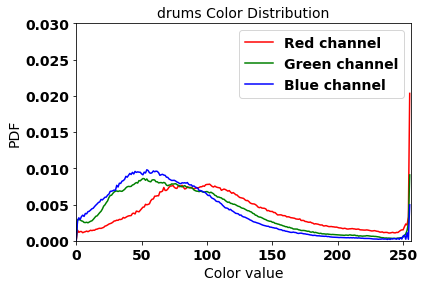

In [35]:
### select drums from the dataframe
drums = df[["name", "path", "drum"]]
drums = drums[(drums[["drum"]] != str(0)).all(axis=1)]
drums.to_csv("../output/analysis/csv/drums.csv")

hist = color_histogram(drums, "drums")
drum_r, drum_g, drum_b = hist.generate()

### Cones

774it [00:12, 62.13it/s]


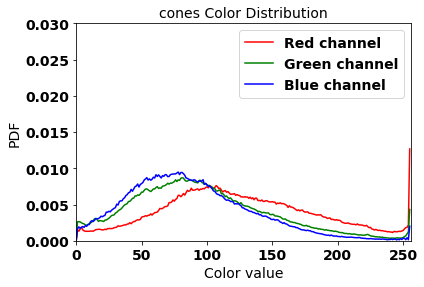

In [36]:
### select cones from the dataframe
cones = df[["name", "path", "cone"]]
cones = cones[(cones[["cone"]] != str(0)).all(axis=1)]
cones.to_csv("../output/analysis/csv/cones.csv")
hist = color_histogram(cones, "cones")
cone_r, cone_g, cone_b = hist.generate()

### Barricade

440it [00:06, 70.26it/s]


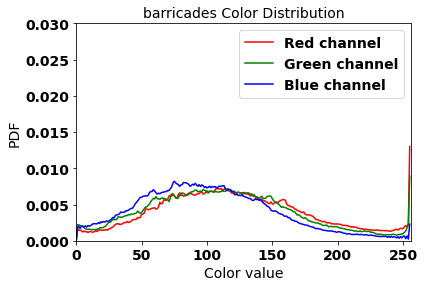

In [37]:
### select barricade from the dataframe
barricades = df[["name", "path", "barricade"]]
barricades = barricades[(barricades[["barricade"]] != str(0)).all(axis=1)]
barricades.to_csv("../output/analysis/csv/barricades.csv")
hist = color_histogram(barricades, "barricades")
barricade_r, barricade_g, barricade_b = hist.generate()

### Board

193it [00:03, 63.02it/s]


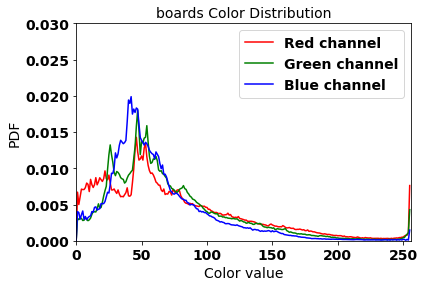

In [38]:
### select board from the dataframe
boards = df[["name", "path", "board"]]
boards = boards[(boards[["board"]] != str(0)).all(axis=1)]
boards.to_csv("../output/analysis/csv/boards.csv")
hist = color_histogram(boards, "boards")
board_r, board_g, board_b = hist.generate()

### Trailer

11it [00:00, 62.05it/s]


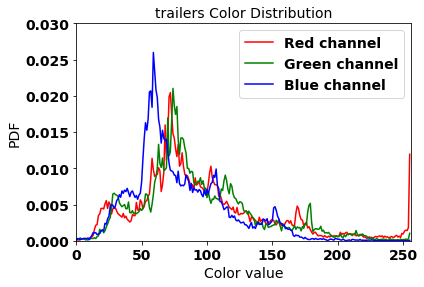

In [39]:
### select trailer from the dataframe
trailers = df[["name", "path", "trailer"]]
trailers = trailers[(trailers[["trailer"]] != str(0)).all(axis=1)]
trailers.to_csv("../output/analysis/csv/trailers.csv")
hist = color_histogram(trailers, "trailers")
trailer_r, trailer_g, trailer_b = hist.generate()

### Machine

250it [00:03, 66.28it/s]


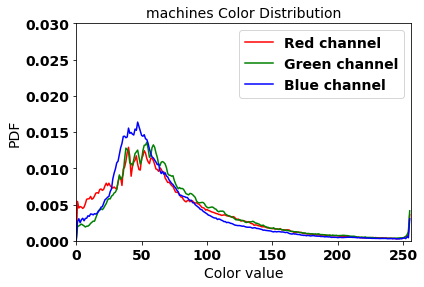

In [40]:
### select machine from the dataframe
machines = df[["name", "path", "machine"]]
machines = machines[(machines[["machine"]] != str(0)).all(axis=1)]
machines.to_csv("../output/analysis/csv/machines.csv")
hist = color_histogram(machines, "machines")
machine_r, machine_g, machine_b = hist.generate()

### Sign

537it [00:08, 66.89it/s]


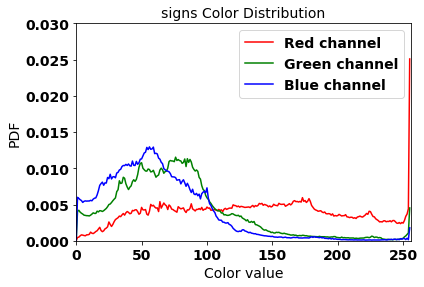

In [41]:
### select sign from the dataframe
signs = df[["name", "path", "sign"]]
signs = signs[(signs[["sign"]] != str(0)).all(axis=1)]
signs.to_csv("../output/analysis/csv/signs.csv")
hist = color_histogram(signs, "signs")
sign_r, sign_g, sign_b = hist.generate()

### Barrier

471it [00:06, 68.81it/s]


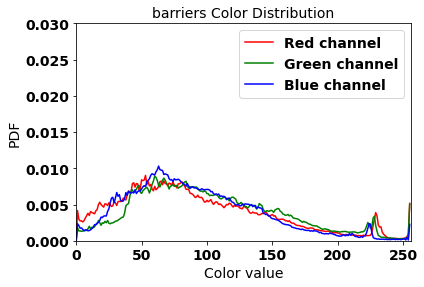

In [42]:
### select barrier from the dataframe
barriers = df[["name", "path", "barrier"]]
barriers = barriers[(barriers[["barrier"]] != str(0)).all(axis=1)]
barriers.to_csv("../output/analysis/csv/barriers.csv")
hist = color_histogram(barriers, "barriers")
barrier_r, barrier_g, barrier_b = hist.generate()

### Person

122it [00:02, 57.59it/s]


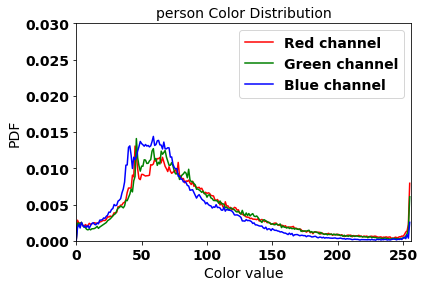

In [43]:
### select person from the dataframe
person = df[["name", "path", "person"]]
person = person[(person[["person"]] != str(0)).all(axis=1)]
person.to_csv("../output/analysis/csv/person.csv")
hist = color_histogram(person, "person")
person_r, person_g, person_b = hist.generate()

### All

True True True
1.0 1.0 1.0
mean R value: 98
 mean G value: 94
 mean B value: 83


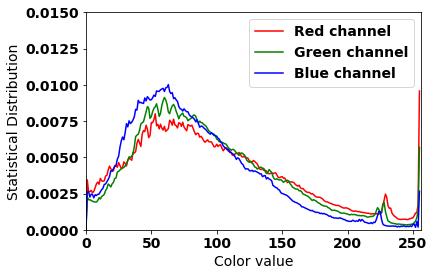

In [44]:
all_r = np.concatenate((drum_r, cone_r, machine_r, sign_r, trailer_r, person_r, barricade_r, barrier_r, board_r))
all_g = np.concatenate((drum_g, cone_g, machine_g, sign_g, trailer_g, person_g, barricade_g, barrier_g, board_g))
all_b = np.concatenate((drum_b, cone_b, machine_b, sign_b, trailer_b, person_b, barricade_b, barrier_b, board_b))


histogram_r, bin_edges_r = np.histogram(all_r, bins=256, range=(0, 256), density=True)
plt.plot(bin_edges_r[0:-1], histogram_r, color='r', label="Red channel")

histogram_g, bin_edges_g = np.histogram(all_g, bins=256, range=(0, 256), density=True)
plt.plot(bin_edges_g[0:-1], histogram_g, color='g', label="Green channel")

histogram_b, bin_edges_b = np.histogram(all_b, bins=256, range=(0, 256), density=True)
plt.plot(bin_edges_b[0:-1], histogram_b, color='b', label="Blue channel")

# sanity check
print(np.all(np.diff(bin_edges_r)==1), np.all(np.diff(bin_edges_g)==1), np.all(np.diff(bin_edges_b)==1))
print(np.sum(histogram_r), np.sum(histogram_g), np.sum(histogram_b))


print(f"mean R value: {int(np.mean(all_r))}\n", f"mean G value: {int(np.mean(all_g))}\n", f"mean B value: {int(np.mean(all_b))}")
plt.axis([0, 256, 0, 0.0150])
plt.xlabel("Color value",fontsize=14)
plt.ylabel("Statistical Distribution", fontsize=14)
#plt.title(f"Color Distribution", fontsize=14)
plt.legend(loc="upper right")
plt.savefig(f"../output/analysis/color_distribution/all_objects_color_distribution.png", dpi=250, bbox_inches = "tight")
plt.show() 